# Spaceship Titanic Kaggle Competition, by [Andres Perez](https://www.andresperez.info/)
[README](./README.md)

## Imports

In [1]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling tools
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

## Read in the Data

In [2]:
train = pd.read_csv('./data/train.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
test = pd.read_csv('./data/test.csv')
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## EDA
Using this notebook as a guide: [Geunho](https://www.kaggle.com/code/arootda/pycaret-visualization-optimization-0-81/data)

### Combine Train and Test data for EDA

In [4]:
data = pd.concat([train, test]).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


### Missing values

In [5]:
# Percentages of missing data
(data.isna().sum() / len(data)) * 100

PassengerId      0.000000
HomePlanet       2.220509
CryoSleep        2.390131
Cabin            2.305320
Destination      2.112567
Age              2.081727
VIP              2.282190
RoomService      2.027756
FoodCourt        2.228219
ShoppingMall     2.359291
Spa              2.189668
VRDeck           2.066307
Name             2.266769
Transported     32.976099
dtype: float64

Small amount of missing values, but filling them is better than dropping. Numericals will probably be filled with means, categoricals with modes. I have read in other notebooks that missing values in the spending categories can be correlated with CryoSleep category.

### Identify feature types

- Categorical: PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP, Name
- Numerical: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
- Target: Transported

In [6]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [7]:
# Build lists of features by type for easy panda df usage. Borrowed idea from Geunho
categoricals = [
    "PassengerId",
    "HomePlanet",
    "CryoSleep",
    "Cabin",
    "Destination",
    "VIP",
    "Name",
]

numericals = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

target = "Transported"


In [8]:
# Descriptive Statistics for numerical features
data[numericals].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### Explore Feature Distributions

#### Target Variable: Transported

Our target is categorical True/False. Check distribution to make sure it's balanced

''

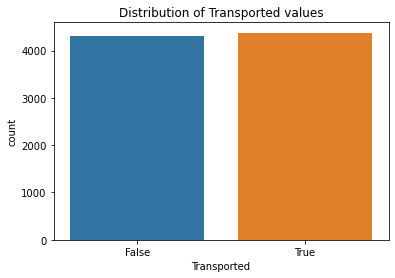

In [9]:
# Plot target distribution to verify balanced data
sns.countplot(data=data["Transported"], x=data["Transported"])
plt.title('Distribution of Transported values')
;

#### Categorical Features

##### PassengerId

Passenger groups are hidden in the first four characters of this feature. Will use to create a IsFamily feature.

In [10]:
# Create Group, Id and Last Name features
tmp = data.copy()
tmp['Group'] = tmp['PassengerId'].apply(lambda x: str(x)[0:4])
tmp['Id'] = tmp['PassengerId'].apply(lambda x: int(str(x)[5:]))
tmp['LastName'] = tmp['Name'].apply(lambda x: str(x).split()[1] if len(str(x).split()) > 1 else str(x).split()[0])
tmp.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,LastName
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,1,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,Santantines


In [11]:
tmp["IsFamily"] = tmp["Group"].map(
    tmp.groupby(by=["Group"]).count()["PassengerId"] > 1
).map({True: 1, False: 0})


In [12]:
tmp.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,LastName,IsFamily
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,Vines,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,1,Susent,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2,Susent,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,Santantines,0


In [13]:
tmp['IsFamily'].value_counts()

0    7145
1    5825
Name: IsFamily, dtype: int64

''

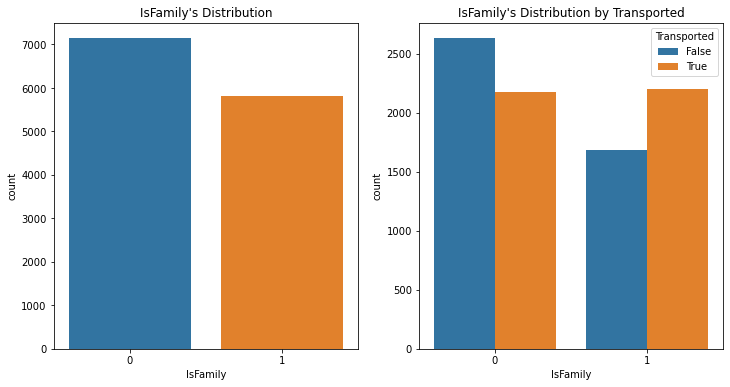

In [14]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'IsFamily'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

##### HomePlanet

''

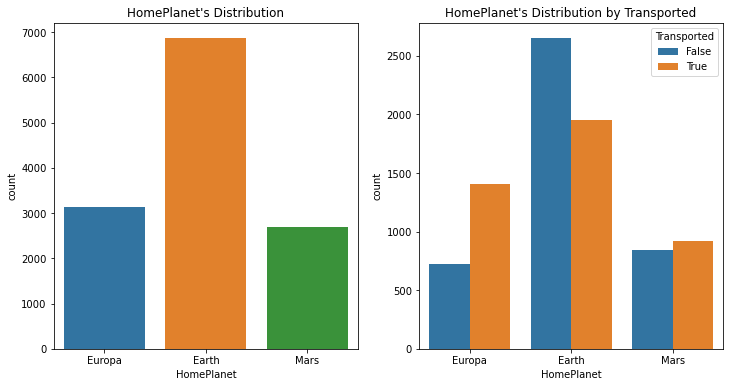

In [15]:
# Plot HomePlanet distribution and distribution by target. With help from Geunho's functions
feature = 'HomePlanet'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

##### CryoSleep

''

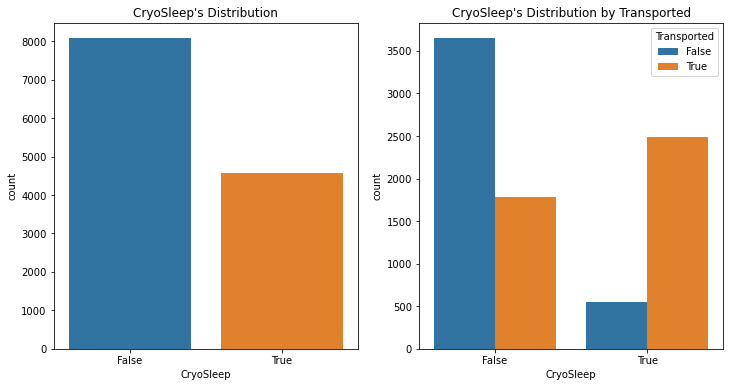

In [16]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'CryoSleep'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

##### Cabin

Too many cabins for this plot to be useful. Will separate cabin feature by deck/number/side.

In [17]:
# Create Deck, Number and Side features from Cabin. Use temporary copy of data
tmp = data.copy()
tmp['Deck'] = tmp['Cabin'].apply(lambda x: str(x)[0])
tmp['Number'] = tmp['Cabin'].apply(lambda x: str(x)[2])
tmp['Side'] = tmp['Cabin'].apply(lambda x: str(x)[-1])
tmp.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


''

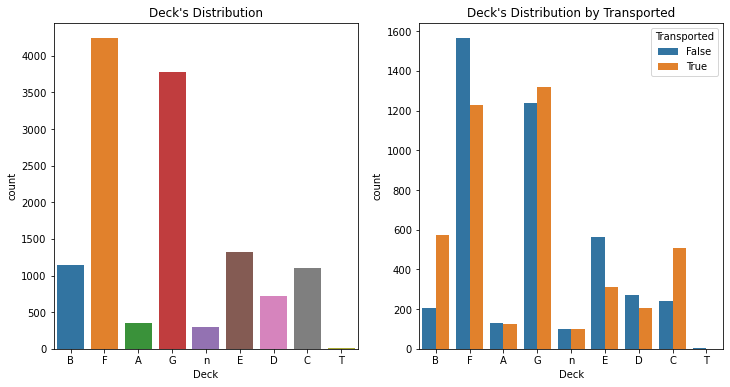

In [18]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Deck'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

''

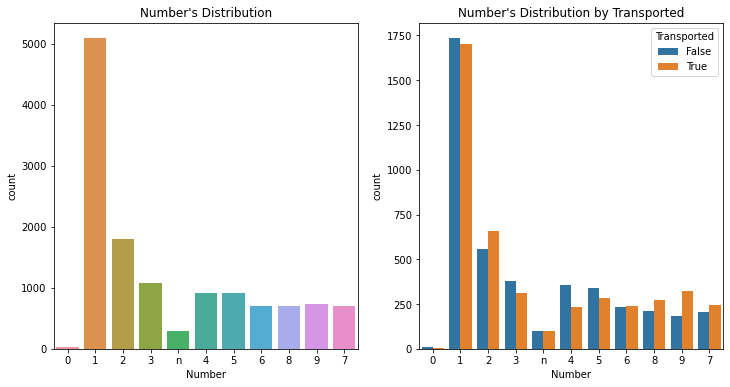

In [19]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Number'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

''

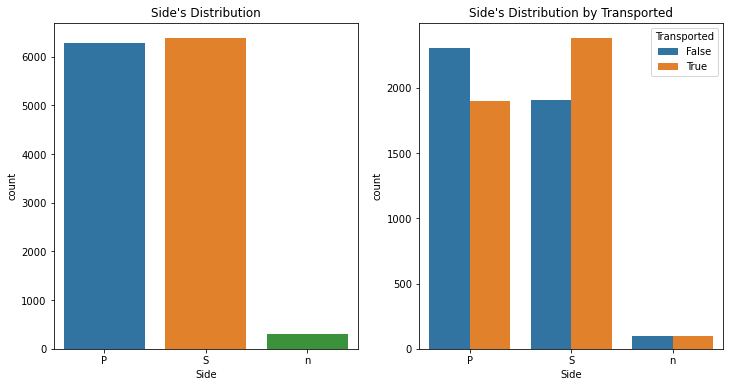

In [20]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Side'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

##### Destination

''

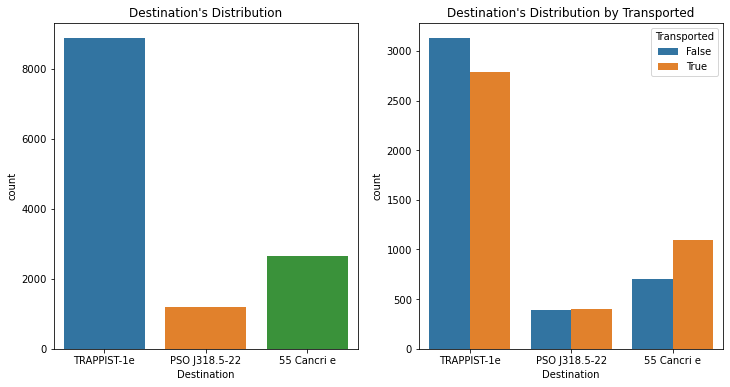

In [21]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Destination'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

##### VIP

''

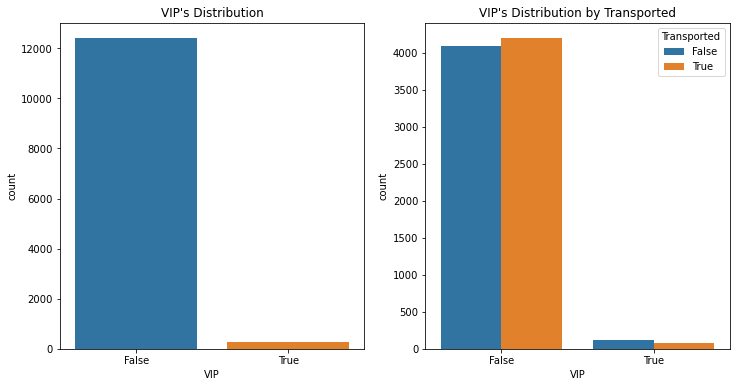

In [22]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'VIP'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

#### Numerical Features

In [23]:
numericals

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

##### Age

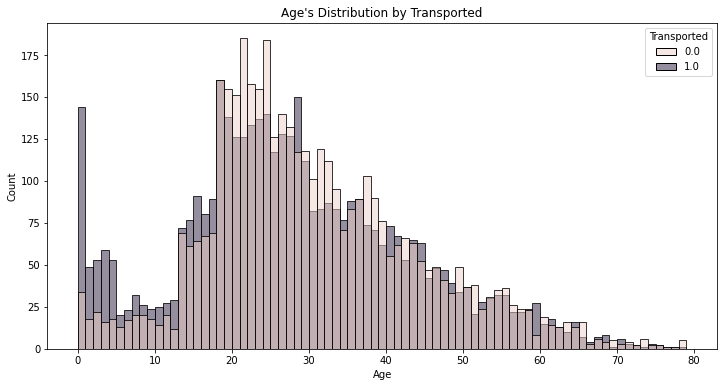

In [24]:
# Plot distribution by target. With help from Geunho's functions
feature = 'Age'
plt.figure(figsize=(12, 6))
plt.title(f"{feature}'s Distribution by Transported")
sns.histplot(
    data=data,
    x=data[feature],
    hue=data['Transported'],
    binwidth=1,
)
;
plt.savefig(f"./figures/{feature}-distro-by-transported.png")

It appears that up to age 18 there are consistently more Transported individuals than not. Should come back and test this quantitatively.

>Create Underage feature

##### Total Spending

Group spending features into total spending

In [25]:
tmp = data.copy()
tmp['TotalSpend'] = tmp['RoomService'] + tmp['FoodCourt'] + tmp['ShoppingMall'] + tmp['Spa'] + tmp['VRDeck']

''

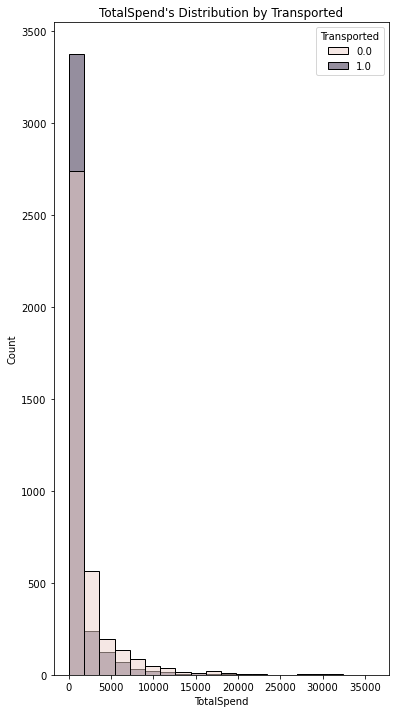

In [26]:
# Plot distribution by target. With help from Geunho's functions
feature = 'TotalSpend'
plt.figure(figsize=(6, 12))
plt.title(f"{feature}'s Distribution by Transported")
sns.histplot(
    data=tmp,
    x=tmp[feature],
    hue=tmp['Transported'],
    bins=20,
)
;

> Create DidNotSpend feature